In [1]:
from networkx.linalg.laplacianmatrix import laplacian_matrix
from networkx.generators.random_graphs import gnp_random_graph
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import cholesky
import random
import cvxpy as cp
from networkx.drawing.nx_pylab import draw

sns.set()

## Min vol ellipsoid

As in slides, the center of an ellipsoid covering two given sets is: $x_c=-\frac{1}{1+n}\frac{P_0w}{\sqrt{w^TP_0w}}$ and its generating matrix $P=\frac{n^2}{n^2-1}(P_0-\frac{2P_0ww^TP_0}{(n+1)w^TP_0w})$

In [2]:
pmat0 = np.array([[1, 0], [0, 4]])

In [3]:
def get_pmatrix(pmat0, n, w):
    return (
        n ** 2
        / (n ** 2 - 1)
        * (pmat0 - 2 / (n + 1) * pmat0 @ w @ w.T @ pmat0 / (w.T @ pmat0 @ w))
    )


def get_center(pmat0, n, w):
    return -1 / (n + 1) * pmat0 @ w / np.sqrt(w.T @ pmat0 @ w)

Thus from ellipsoid equation $(x-x_c)^TP^{-1}(x-x_c)$ we will have:

In [4]:
def ellipse(x, y, xc, pmat):
    xc = xc.ravel()
    p = np.linalg.inv(pmat)

    cx = xc[0]
    cy = xc[1]

    return (
        (x - cx) ** 2 * p[0, 0]
        + (y - cy) ** 2 * p[1, 1]
        + (x - cx) * (y - cy) * (p[1, 0] + p[0, 1])
        - 1
    )

Case 1

In [18]:
w = np.array([[1], [0]])
n = len(w)

pmat = get_pmatrix(pmat0, n, w)
xc = get_center(pmat0, n, w)
w = w.ravel()

print(pmat, "\n")
print(xc)

[[0.44444444 0.        ]
 [0.         5.33333333]] 

[[-0.33333333]
 [ 0.        ]]


The volume for our case is $vol(\epsilon)=\det P^{-1/2}$

In [19]:
vol = np.linalg.det(np.linalg.inv(pmat)) ** 0.5
vol0 = np.linalg.det(np.linalg.inv(pmat0)) ** 0.5
vol / vol0

1.299038105676658

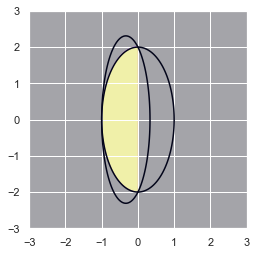

In [20]:
lim = 3
x, y = np.meshgrid(np.linspace(-lim, lim, 1000), np.linspace(-lim, lim, 1000))

plt.imshow(
    (
        (ellipse(x, y, xc, pmat) <= 0)
        & (ellipse(x, y, 0 * xc, pmat0) <= 0)
        & (w[0] * x + w[1] * y <= 0)
    ).astype(int),
    extent=(x.min(), x.max(), y.min(), y.max()),
    origin="lower",
    cmap="gnuplot",
    alpha=0.3,
)

plt.contour(x, y, ellipse(x, y, xc, pmat), [0])
plt.contour(x, y, ellipse(x, y, 0 * xc, pmat0), [0])
plt.show()

Case 2

In [21]:
w = np.array([[1 / 2], [-1 / 2]])
n = len(w)

pmat = get_pmatrix(pmat0, n, w)
xc = get_center(pmat0, n, w)
w = w.ravel()

print(pmat, "\n")
print(xc)

[[1.15555556 0.71111111]
 [0.71111111 2.48888889]] 

[[-0.1490712 ]
 [ 0.59628479]]


In [22]:
vol = np.linalg.det(np.linalg.inv(pmat)) ** 0.5
vol / vol0

1.299038105676658

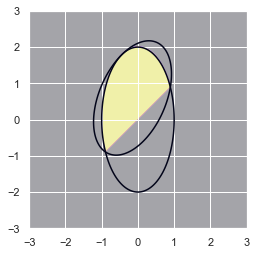

In [23]:
lim = 3
x, y = np.meshgrid(np.linspace(-lim, lim, 1000), np.linspace(-lim, lim, 1000))

plt.imshow(
    (
        (ellipse(x, y, xc, pmat) <= 0)
        & (ellipse(x, y, 0 * xc, pmat0) <= 0)
        & (w[0] * x + w[1] * y <= 0)
    ).astype(int),
    extent=(x.min(), x.max(), y.min(), y.max()),
    origin="lower",
    cmap="gnuplot",
    alpha=0.3,
)

plt.contour(x, y, ellipse(x, y, xc, pmat), [0])
plt.contour(x, y, ellipse(x, y, 0 * xc, pmat0), [0])
plt.show()

## Schur complement

From ellipsoid set condition we have: $1-(x-c)^TP^{-1}(x-c)\geq0$
Thus, from complement $C-B^TA^{-1}B\succ0\implies C=1,B=(x-c),A=P$. Now for $x=a$ we have:
$X\succeq0\implies\begin{bmatrix}
P & a-c\\
(a-c)^T & 1
\end{bmatrix}\succeq0$. Here we can take only this complement $(A\succ0)$ since for ellipsoid $P\succ0$

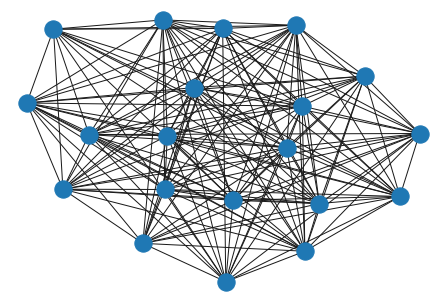

In [11]:
n = 20
p = 0.9
g = gnp_random_graph(n, p)

for (u, v, w) in g.edges(data=True):
    w["weight"] = np.random.rand()

lmat = laplacian_matrix(g).toarray()
draw(g)

In [12]:
np.count_nonzero(lmat) / lmat.size

0.895

In [13]:
xmat = cp.Variable((n, n), PSD=True)
# constraints = [cp.diag(xmat) == np.ones(n)]
constraints = [xmat[i, i] == 1 for i in range(n)]
problem = cp.Problem(cp.Maximize(cp.trace(lmat @ xmat)), constraints)
problem.solve(solver="CVXOPT")
maxval = problem.value
print("The optimal value is", problem.value)
xval = xmat.value
vmat = cholesky(xval)

The optimal value is 222.05470933406002


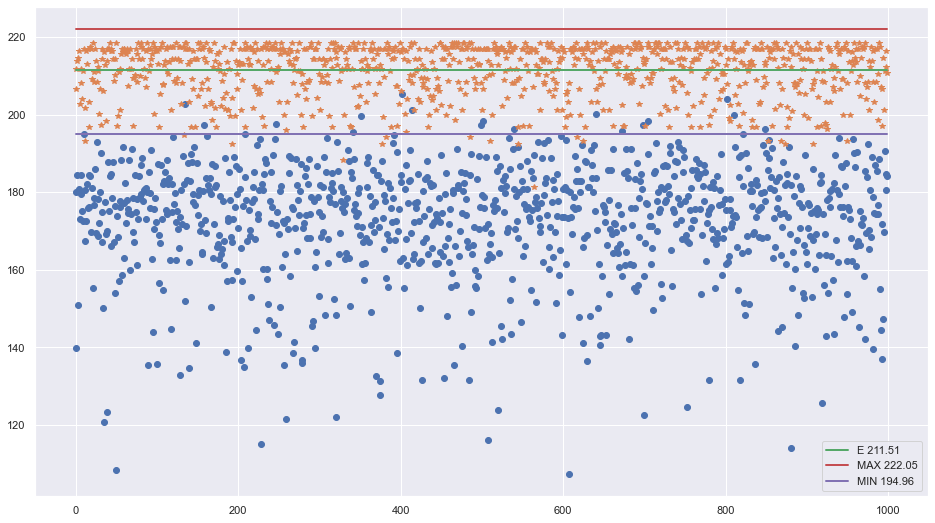

In [14]:
s = 1000
x = np.random.randint(2, size=(s, n))
x[x == 0] = -1
xi = np.random.randn(s, n)

objectives = []
goemans = []
for i in range(s):
    _x = x[i].reshape(-1, 1)
    _xi = xi[i].reshape(-1, 1)
    _xi /= np.linalg.norm(_xi, ord=2)
    xbar = np.sign(vmat.T @ _xi)
    fxbar = xbar.T @ lmat @ xbar
    goemans.append(fxbar.item())
    fx = _x.T @ lmat @ _x
    objectives.append(fx.item())

# maxval = np.max(goemans)
plt.figure(figsize=(16, 9))
plt.plot(range(s), objectives, "o")
plt.plot(range(s), goemans, "*")
plt.plot(
    range(s), [np.mean(goemans)] * s, linewidth=2, label="E %.2f" % np.mean(goemans)
)
plt.plot(range(s), [maxval] * s, linewidth=2, label="MAX %.2f" % maxval)
plt.plot(
    range(s), [0.878 * maxval] * s, linewidth=2, label="MIN %.2f" % (0.878 * maxval),
)
plt.legend()
plt.show()

In [45]:
amat = np.array(
    [
        [18, 15, 23, 12, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 18, 15, 23, 12, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 18, 15, 23, 12],
        [18 * 480, 15 * 650, 23 * 580, 12 * 390, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 18 * 480, 15 * 650, 23 * 580, 12 * 390, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 18 * 480, 15 * 650, 23 * 580, 12 * 390],
        [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
    ]
)
b=np.array(
    [
        [10],
        [16],
        [8],
        [6800],
        [8700],
        [5300],
    ]
)

In [43]:
amat.shape

(10, 12)

In [44]:
amat

array([[   18,    15,    23,    12,     0,     0,     0,     0,     0,
            0,     0,     0],
       [    0,     0,     0,     0,    18,    15,    23,    12,     0,
            0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,    18,
           15,    23,    12],
       [ 8640,  9750, 13340,  4680,     0,     0,     0,     0,     0,
            0,     0,     0],
       [    0,     0,     0,     0,  8640,  9750, 13340,  4680,     0,
            0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,  8640,
         9750, 13340,  4680],
       [    1,     0,     0,     0,     1,     0,     0,     0,     1,
            0,     0,     0],
       [    0,     1,     0,     0,     0,     1,     0,     0,     0,
            1,     0,     0],
       [    0,     0,     1,     0,     0,     0,     1,     0,     0,
            0,     1,     0],
       [    0,     0,     0,     1,     0,     0,     0,     1,     0,
            0,     0

In [33]:
18*480

8640